In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

I've chosen Quantum Teleportation as an example i will work on to analyse:
* state amplitudes
* density matrix
* differences beetwen simulated and real computer histograms

(my first choice was QFT, which appeared to be very poor choice)

# Circuit construction

In [19]:
def one():
    qc = QuantumCircuit(3, 3)
    qc.x(0)
    return qc

def zero():
    qc = QuantumCircuit(3, 3)
    return qc

def teleportation_circuit(state_to_teleport, ideal_case=True, deffer_measurements=False):
    # q[0] to be teleported
    state_to_teleport.barrier()
    state_to_teleport.h(1)
    state_to_teleport.cx(1, 2)
    state_to_teleport.barrier()
    state_to_teleport.cx(0, 1)
    state_to_teleport.h(0)
    state_to_teleport.barrier()
    if not ideal_case:
        state_to_teleport.measure(0, 0)
        state_to_teleport.measure(1, 1)
    state_to_teleport.cx(1, 2)
    state_to_teleport.cz(0, 2)
    state_to_teleport.barrier()
    state_to_teleport.measure(2, 2)
    if deffer_measurements:
        state_to_teleport.measure(0, 0)
        state_to_teleport.measure(1, 1)
    return state_to_teleport

How will it look like for teleporting 1?

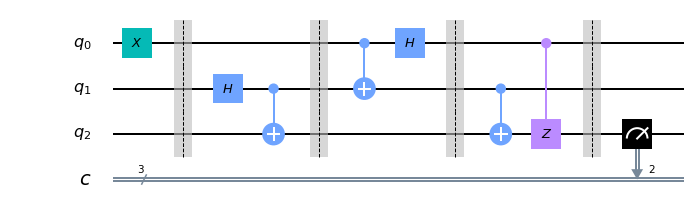

In [3]:
qc = teleportation_circuit(one())
qc.draw(output='mpl')

# Experiments & analysis

In [4]:
from qiskit.visualization import plot_state_city
from qiskit.tools.monitor import job_monitor

qc = teleportation_circuit(one())
qc.draw(output='mpl')

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[0. +0.j 0. +0.j 0. +0.j 0. +0.j 0.5-0.j 0.5-0.j 0.5-0.j 0.5-0.j]


In [5]:
def pretty_print(state_vec):
    keys = ['000', '001','010', '011', '100', '101', '110', '111']
    return { keys[i]: state_vec[i] for i in range(len(keys))}

pretty_print(outputstate)

{'000': 0j,
 '001': 0j,
 '010': 0j,
 '011': 0j,
 '100': (0.5-0j),
 '101': (0.5-0j),
 '110': (0.5-0j),
 '111': (0.5-0j)}

### Conslusions
As we now teleportation is sending information "faster than light speed". In the example above we send state "1" from q0 to q2. Theoretical, expected outcome is:
* whatever (either 0 or 1, equally probable, speaking more precisely) on qubits 0 and 1
* 1 on qubit 2 (with probability eq 1, after all we have just sent 1)

And that's what the amplitudes above tell us. We can be sure that q2 will be 1, and we can't tell what's on the remainging pair.
The truth is, that we need to measure these two qubits, and send the result via conventional medium, so the owner of q2 will be able to read the result. It slows down the whole process.

In [6]:
qc = teleportation_circuit(one(), ideal_case=False)
qc.draw(output='mpl')

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
pretty_print(outputstate)

{'000': 0j,
 '001': 0j,
 '010': 0j,
 '011': 0j,
 '100': 0j,
 '101': (1-0j),
 '110': 0j,
 '111': 0j}

Amplitudes above show the real case. Fortunatelly, the "1" on q2 remains certain after measurement. Why did it change? Because q0 and q1 collapse after measurements during the "protocol" of teleportation.

Let's get back to 'ideal' case:

In [7]:
qc = teleportation_circuit(one())
qc.draw(output='mpl')

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
outputstate

array([0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.5-0.j, 0.5-0.j, 0.5-0.j,
       0.5-0.j])

As we can easily compute, density matrix for state 1/2('100' + '101' + '110' + '111') is equal to it's transposition, but let's stay strict and ompute it right way:

In [8]:
import numpy as np

bra = np.matrix(outputstate, dtype=np.complex)
ket = bra.getH()
ket

matrix([[0. -0.j],
        [0. -0.j],
        [0. -0.j],
        [0. -0.j],
        [0.5+0.j],
        [0.5+0.j],
        [0.5+0.j],
        [0.5+0.j]])

In [9]:
ket @ bra

matrix([[0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
         0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
         0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
         0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
         0.  +0.j, 0.  +0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
         0.25+0.j, 0.25+0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
         0.25+0.j, 0.25+0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
         0.25+0.j, 0.25+0.j],
        [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j, 0.25+0.j,
         0.25+0.j, 0.25+0.j]])

For redability let's filter all complex parts (since all are 0j)

In [10]:
(ket @ bra).real

matrix([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25],
        [0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.25]])

Having theoretical density matrix, compare it to the simulation one:

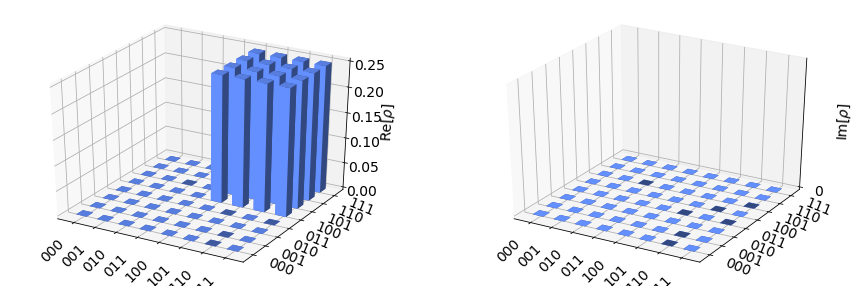

In [11]:
plot_state_city(outputstate)

So far everything is identical to theoretical expectations, there is no imaginary, and we can spot this square of 0.25's

## Simulation

In [20]:
backend_sim = Aer.get_backend('qasm_simulator')

qc = teleportation_circuit(one(), deffer_measurements=True)
job_sim = execute(qc, backend_sim, shots=1024)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qc)
counts_sim

{'100': 247, '101': 262, '111': 256, '110': 259}

Once again, all as expected.

|q2> is always 1

|q1q0> reach all possible values.

Count expected value for each possibility is 256. All counts lay pretty near 256.

In [22]:
provider = IBMQ.get_provider(group='open')
provider.backends()
# i do not choose essex because it's also used in tutorial, as i remember Jamie Oliver lives in essex :D
backend = provider.get_backend('ibmq_essex')

In [24]:
# We need to get rid of measurements in the meantime - current computers don't support gate operations after measurement
qc = teleportation_circuit(one(), deffer_measurements=True)

job_exp = execute(qc, backend=backend)
job_monitor(job_exp)
result_exp = job_exp.result()

Job Status: job has successfully run


In [25]:
counts_exp = result_exp.get_counts(qc)
counts_exp

{'110': 186,
 '011': 49,
 '000': 59,
 '001': 71,
 '100': 222,
 '101': 200,
 '111': 186,
 '010': 51}

I will postpone conclusions until visualization..

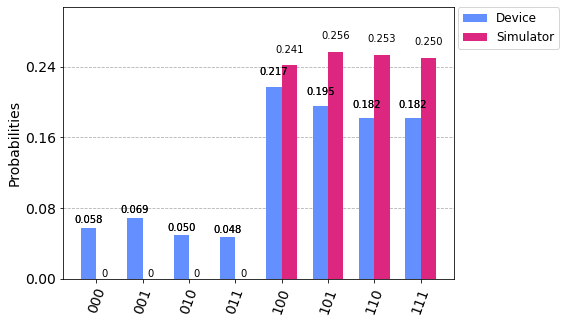

In [26]:
plot_histogram([counts_exp,counts_sim], legend=['Device', 'Simulator'])

## Final conclusions
Device has more bars than simulation - it is proof of decoherence (via observation of it's apperance). Since we teleport state |1>, we expect it to appear on q2. But as the histograms show, states starting with 0 also occure. About 2% of experiments conducted on real machine ended up with corrupted qubit.

That shows difference beetwen real machine run and simulation - simulation results vary, but only because of superposition, while measuring our qubits we expect q1 and q0 to end up either as 0, or as 1, evenly.

Above experiment shows, that randomness of measurement is not the only factor having an impact on result.